# Implement Brown (2008)'s baseball example

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from kw_mle.kw_mle import KWMLE

In [13]:
DATA_PATH = 'D:/py_projects/npeb/MAP/data/brown_2008.csv'
df_raw = pd.read_csv(DATA_PATH)

## Preprocessing

In [14]:
def get_train_test(df_raw):
    MIN_NUM_AB = 10
    ab_s1 = df_raw.iloc[:, [4, 5, 6]]
    s1_bool = ab_s1.sum(axis=1) > MIN_NUM_AB
    train_df = df_raw[s1_bool]

    ab_s2 = df_raw.iloc[:, [7, 8, 9]]
    s2_bool = ab_s2.sum(axis=1) > MIN_NUM_AB
    test_df = df_raw[s1_bool & s2_bool]

    train = train_df[['First Name', 'Last Name', 'AB(4)', 'AB(5)', 'AB(6)', 'H(4)', 'H(5)', 'H(6)']].copy()
    test = test_df[['First Name', 'Last Name', 'AB(7)', 'AB(8)', 'AB(9-10)', 'H(7)', 'H(8)', 'H(9-10)']].copy()

    train['AB'] = train[['AB(4)', 'AB(5)', 'AB(6)']].sum(axis=1)
    train['H'] = train[['H(4)', 'H(5)', 'H(6)']].sum(axis=1)
    test['AB'] = test[['AB(7)', 'AB(8)', 'AB(9-10)']].sum(axis=1)
    test['H'] = test[['H(7)', 'H(8)', 'H(9-10)']].sum(axis=1)

    return train, test

train, test = get_train_test(df_raw)

In [15]:
def variance_stabilizing(num_hit, num_ab):
    """
    A variance stabilizing transformation stated in Brown (2008)
    """
    return np.arcsin(np.sqrt((num_hit + 1 / 4) / (num_ab + 1 / 2)))

train_label = variance_stabilizing(train['H'].values, train['AB'].values)
test_label = variance_stabilizing(test['H'].values, test['AB'].values)
std_train = 1/(2*np.sqrt(train['AB'].values))
std_test = 1/(2*np.sqrt(test['AB'].values))

## Fit the model

In [16]:
kw_mle = KWMLE(train_label, stds=std_train)
kw_mle.fit()

11


## Compare with the naive estimator and James-Stein estimator

In [17]:
def tse(truth, pred, std):
    """
    Total squared error (Brown, 2008)
    """
    return sum((truth - pred) ** 2) - sum(std ** 2)

In [18]:
def james_stein_prediction(y, std):
    """
    Heterogeneous James Stein estimator (Brown, 2008, page 20)
    """
    w = (1 / (std ** 2)) / sum((1 / std) ** 2)
    wlse = [sum(w * y)] * len(y)
    S = sum(((y - wlse) / std) ** 2)
    return wlse + (1 - (len(y) - 3) / S) * (y - wlse)

In [19]:
naive_pred_raw = pd.DataFrame(train_label, index=train.index)
npeb_pred_raw = pd.DataFrame(kw_mle.prediction(train_label, std_train), index=train.index)
js_pred_raw = pd.DataFrame(james_stein_prediction(train_label, std_train), index=train.index)

naive_pred = naive_pred_raw.loc[test.index]
npeb_pred = npeb_pred_raw.loc[test.index]
js_pred = js_pred_raw.loc[test.index]

In [20]:
tse_naive = tse(np.array(test_label), np.array(naive_pred).flatten(), std_test)
tse_npeb = tse(np.array(test_label), np.array(npeb_pred).flatten(), std_test)
tse_js = tse(np.array(test_label), np.array(js_pred).flatten(), std_test)

print("relative total squared error of nonparametric empirical Bayes: ", tse_npeb/tse_naive)
print("relative total squared error of James-Stein estimator: ", tse_js/tse_naive)

relative total squared error of nonparametric empirical Bayes:  0.6874632544417437
relative total squared error of James-Stein estimator:  0.5350256561846592


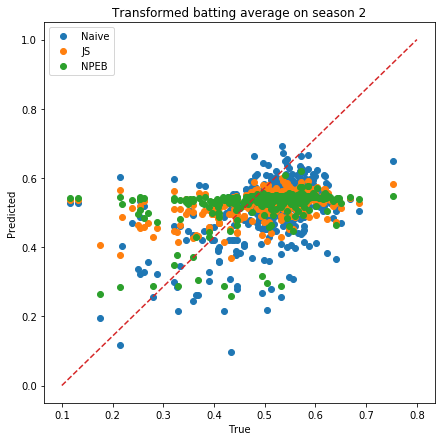

In [42]:
plt.plot(test_label, naive_pred, 'o', label='Naive')
plt.plot(test_label, js_pred, 'o', label='JS')
plt.plot(test_label, npeb_pred, 'o', label='NPEB')
plt.plot(np.linspace(0.1,0.8,50), np.linspace(0,1,50), '--')
plt.rcParams['figure.figsize'] = [7, 7]
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Transformed batting average on season 2')
plt.legend()
plt.show()

REMARK. At first glance, it seems that none of the methods fits that well. However, recall that all the information used to fit the model is the observed batting averages in season 1 (training set). For prediction problems where features/predictors/independent variables are not available, nonparametric empirical Bayes provides an solution.